<a href="https://colab.research.google.com/github/nickprock/appunti_data_science/blob/master/semantic-search/advent-of-haystack/Advent_of_Haystack_Route_to_websearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advent of Haystack - Day 7
_Make a copy of this Colab to start!_

Pipelines can also have conditional routes! In this challenge, Elf Tuana had the idea to create a pipeline with conditional routing. The idea was to have a system where given a question, we determine if the answer is in our document, and if not we do websearch 🌍.

Your challenge is to complete the pipeline in **Step 3** to make sure it goes down the correct route based on whether the answer to a question exists in our document or not.

[📚 Conditional Router docs](https://docs.haystack.deepset.ai/v2.0/docs/conditionalrouter)

**Your task is to complete step 3 👇**

#Installation
**Note:** There is a known issue with colab due to a version conflict error related to `llmx` which comes with Colab. You might get an `llmx` error. You can safely ignore this, or run `pip uninstall -y llmx`

In [ ]:
%%capture
pip install haystack-ai

Run this code and you’ll be prompted to enter your openAI credentials. If you don’t have a key, [follow these instructions](https://help.openai.com/en/articles/4936850-where-do-i-find-my-api-key).

As for the Serper API Key, we're giving you one for this challenge. You can copy paste this: `7c4ffb0e3ee54fc11dd486465677038f342344b8`

In [ ]:
from getpass import getpass

openai_api_key = getpass("Enter OpenAI Api key: ")
serper_api_key = getpass('Enter Serper Api key:')

Enter OpenAI Api key: ··········
Enter Serper Api key:··········


## 1) Create our Document

This is a Document about Munich, where the answers to our questions will be initially searched.

In [ ]:
from haystack.dataclasses import Document

documents = [Document(content="""Munich, the vibrant capital of Bavaria in southern Germany, exudes a perfect blend of rich cultural
                                heritage and modern urban sophistication. Nestled along the banks of the Isar River, Munich is renowned
                                for its splendid architecture, including the iconic Neues Rathaus (New Town Hall) at Marienplatz and
                                the grandeur of Nymphenburg Palace. The city is a haven for art enthusiasts, with world-class museums like the
                                Alte Pinakothek housing masterpieces by renowned artists. Munich is also famous for its lively beer gardens, where
                                locals and tourists gather to enjoy the city's famed beers and traditional Bavarian cuisine. The city's annual
                                Oktoberfest celebration, the world's largest beer festival, attracts millions of visitors from around the globe.
                                Beyond its cultural and culinary delights, Munich offers picturesque parks like the English Garden, providing a
                                serene escape within the heart of the bustling metropolis. Visitors are charmed by Munich's warm hospitality,
                                making it a must-visit destination for travelers seeking a taste of both old-world charm and contemporary allure.""")]

## 2) Create the components of our Pipeline

- Prompt Builder
- GPT Generator
- SerperDev WebSearch

In [ ]:
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import GPTGenerator
from haystack.components.websearch.serper_dev import SerperDevWebSearch

prompt_template = """
Answer the following query given the douments.
If the answer is not contained within the documents reply with 'no_answer'
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

prompt_builder = PromptBuilder(template=prompt_template)
llm = GPTGenerator(api_key=openai_api_key)

websearch = SerperDevWebSearch(api_key=serper_api_key)

prompt_builder_from_search = PromptBuilder(template=prompt_template)
llm_from_search = GPTGenerator(api_key=openai_api_key)

## 3) Define the Conditional Router

This is the component that handles data routing on specific conditions.

In this case, we want to define two routes:
- if "no_answer" is contained in the llm reply, we want to call Web Search, so we put the original `query` in the output value and the output name is `go_to_websearch`
- otherwise, we put the llm reply in the output named `answer`

In [ ]:
from haystack.components.routers import ConditionalRouter

######## Complete this section #############
routes = [
        {
            "condition": "{{'no_answer' in replies}}",
            "output": "{{query}}",
            "output_name": "go_to_websearch",
            "output_type": str,
        },
        {
            "condition": "{{'no_answer' not in replies}}",
            "output": "{{replies}}",
            "output_name": "answer",
            "output_type": str,
        },
]
############################################

router = ConditionalRouter(routes)

## 4) Build the Pipeline

We put together and connect the components we already created.

In [ ]:
from haystack import Pipeline


pipe = Pipeline()
pipe.add_component("prompt_builder", prompt_builder)
pipe.add_component("llm", llm)
pipe.add_component("router", router)
pipe.add_component("websearch", websearch)
pipe.add_component("prompt_builder_from_search", prompt_builder_from_search)
pipe.add_component("llm_from_search", llm_from_search)

pipe.connect("prompt_builder", "llm")
pipe.connect("llm.replies", "router.replies")
pipe.connect("router.go_to_websearch", "websearch.query")
pipe.connect("router.go_to_websearch", "prompt_builder_from_search.query")
pipe.connect("websearch.documents", "prompt_builder_from_search.documents")
pipe.connect("prompt_builder_from_search", "llm_from_search")

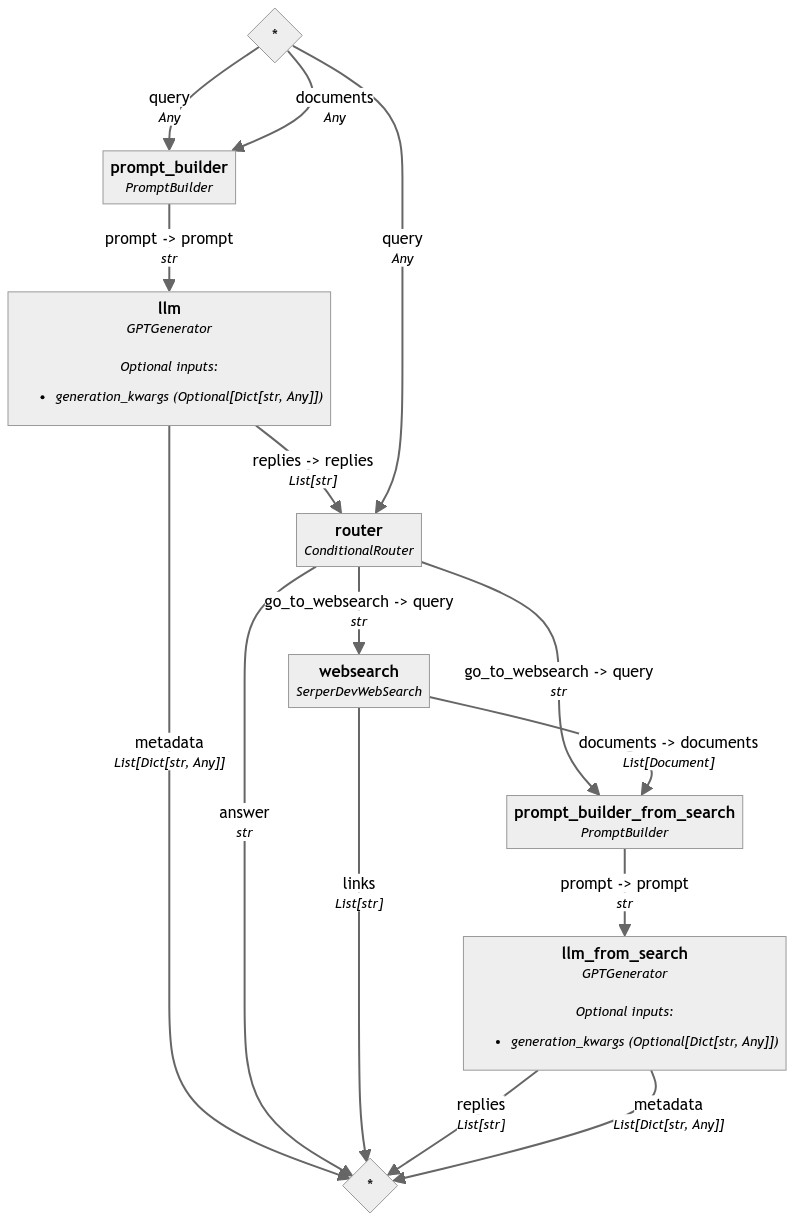

In [ ]:
pipe.draw('pipe.png')
from PIL import Image
Image.open('pipe.png')

## 5) Try the Pipeline!

In [ ]:
query = "Where is Munich?"

pipe.run(data={"prompt_builder":{"query": query, "documents": documents}, "router":{"query":query}})

{'llm': {'metadata': [{'model': 'gpt-3.5-turbo-0613',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'prompt_tokens': 269,
     'completion_tokens': 14,
     'total_tokens': 283}}]},
 'router': {'answer': ['Munich is the vibrant capital of Bavaria in southern Germany.']}}

In [ ]:
query = "How many people live in Munich?"
pipe.run(data={"prompt_builder":{"query": query, "documents": documents}, "router":{"query":query}})

{'llm': {'metadata': [{'model': 'gpt-3.5-turbo-0613',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'prompt_tokens': 272,
     'completion_tokens': 2,
     'total_tokens': 274}}]},
 'websearch': {'links': ['https://en.wikipedia.org/wiki/Munich',
   'https://worldpopulationreview.com/world-cities/munich-population',
   'https://en.wikipedia.org/wiki/Demographics_of_Munich',
   'https://www.macrotrends.net/cities/204371/munich/population',
   'https://www.britannica.com/place/Munich-Bavaria-Germany',
   'https://www.statista.com/statistics/519723/munich-population-by-age-group/',
   'https://www.citypopulation.de/en/germany/bayern/m%C3%BCnchen_stadt/09162000__m%C3%BCnchen/',
   'https://www.statista.com/statistics/519704/munich-population-by-gender/',
   'https://www.quora.com/How-many-people-live-in-Munich',
   'https://earth.esa.int/web/earth-watching/image-of-the-week/content/-/article/munich-germany/']},
 'llm_from_search': {'replies': ['The population of Munich is 1,487